In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from src.config import *
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve
import json
from functools import reduce
import matplotlib.patheffects as path_effects



In [3]:
from src.model_creation.CreateModelFunctions import fit_linear_model_and_get_coefficients_by_receptor as fit_model
from src.prediction_functions.MatrixMultiplicationMemoryEffectiveChunks import estimation_with_zscore_calculation_in_chunks as estimate_receptor_activity


In [4]:
def set_perturabtion_type_values(perturbation, pert_type_lists):
    if perturbation in pert_type_lists['compound_list']: perturbation_type = 'cp'
    elif perturbation in pert_type_lists['ligand_list']: perturbation_type = 'lig'
    elif perturbation in pert_type_lists['receptor_list']: perturbation_type = 'rec'
    else: perturbation_type = np.nan
    return perturbation_type

In [5]:
def determine_type_of_perturbation_of_samples(data_index, data_index_perturbation, pert_type_lists):
    pert_types = pd.DataFrame(columns = ['perturbation', 'perturbation_type'], dtype='str')
    pert_types['perturbation'] = data_index_perturbation
    pert_types['perturbation_type'] = pert_types['perturbation'].apply(lambda x: set_perturabtion_type_values(x, pert_type_lists)) 
    pert_types.index = data_index
    return pert_types

In [6]:
def calculate_roc_auc_sample(estimated_activities, true_matrix):
    # for every ligand calculate rocauc
    rocaucs = {}
    for sample in estimated_activities.index:
        if true_matrix.loc[sample, :].sum() < 1:
            print(sample, ' not considered')
            continue
        rocaucs[sample] = roc_auc_score(y_true = true_matrix.loc[sample, :], y_score = estimated_activities.loc[sample, :])
    return rocaucs

In [7]:
def calculate_roc_auc(estimated_activities, true_matrix):
    # for every ligand calculate rocauc
    rocaucs = {}
    for ligand in estimated_activities.columns:
        if true_matrix.loc[:, ligand].sum() < 1:
            print(ligand, ' not considered')
            continue
        rocaucs[ligand] = roc_auc_score(y_true = true_matrix.loc[:, ligand], y_score = estimated_activities.loc[:, ligand])
    return rocaucs

# Read in data

In [9]:
confidence_scores = pd.read_csv(f'results/confidence/receptor_rocauc_mean_confidence_scores_s0_229.csv', index_col = 0)

In [10]:
# lincs_consensus_inf = pd.read_csv(f'data/lincs_consensus/high_quality/inf_pert_cell_liana_transp.csv', index_col=0)


In [11]:
# file_path = 'data/lincs_consensus/high_quality/inf_pert_cell_liana_transp.csv'

# chunk_size = 1000
# chunks = []
# for chunk in pd.read_csv(file_path, chunksize=chunk_size):
#     chunks.append(chunk)

# lincs_consensus_inf = pd.concat(chunks, ignore_index=True)

In [12]:
a_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'A']['Receptor'])
b_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'B']['Receptor'])
c_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'C']['Receptor'])
d_scored_receptors = list(confidence_scores[confidence_scores['Confidence'] == 'D']['Receptor'])

In [13]:
lincs_consensus = pd.read_csv(f'data/lincs_consensus/high_quality/lm_all_pert_cell_liana.csv', index_col=0)
lincs_design_matrix = pd.read_csv(f'data/design_matrices/high_quality/all_pert_binary_liana.csv', index_col = 0)
lincs_model = pd.read_csv(f'data/coefficient_matrix/high_quality/all_pert_coef_liana.csv', index_col =0)
lincs_model = lincs_model.T


In [14]:
lincs_model_A = lincs_model.loc[:, a_scored_receptors]
lincs_model_B = lincs_model.loc[:, b_scored_receptors]
lincs_model_C = lincs_model.loc[:, c_scored_receptors]
lincs_model_D = lincs_model.loc[:, d_scored_receptors]

In [15]:
lincs_data = pd.read_csv(f'data/lincs_consensus/high_quality/lm_all_pert_cell_liana.csv', index_col = 0)


In [16]:
# data
cytosig_data = pd.read_csv(f'data/cytosig/diff.merge.gz', compression='gzip', sep = '\t')
cytosig_data = cytosig_data.T
# cytosig_data = cytosig_data.fillna(0)

In [17]:
nan_counts = cytosig_data.isna().sum()
columns_to_drop = nan_counts[nan_counts > 10].index
cytosig_data = cytosig_data.drop(columns=columns_to_drop)
cytosig_data = cytosig_data.fillna(0)

In [18]:
lr_associations = pd.read_csv(LIG_REC_DF, index_col = 0)
lr_associations = lr_associations[['source_genesymbol', 'target_genesymbol']]

In [19]:
compound_info = pd.read_csv('data/filtered_lincs_meta/filtered_coumpound_info_to_receptor_perturbation_signatures_signed.csv', index_col =0)
compound_info = compound_info[['cmap_name', 'target', 'sign']].reset_index(drop=True)

In [20]:
# Create perturbation metadata series
lincs_compounds_list = list(compound_info.cmap_name.unique())
lincs_ligand_list = list(lincs_data.index[(lincs_data.reset_index()['index'].str.split('_', expand = True)[2] == 'lig')].str.split('_', expand = True).get_level_values(0).unique())

In [21]:
pert_type_lists = {}
pert_type_lists['compound_list'] = lincs_compounds_list
pert_type_lists['ligand_list'] = list(lr_associations.source_genesymbol) + lincs_ligand_list
pert_type_lists['receptor_list'] = list(lr_associations.target_genesymbol)


# Matching data

In [22]:
additional_mapping = {
       'IFNA':'IFNA1', 
       'IFNB':'IFNB1',
       'IFNL':'IFNL1', 
       'TNFA':'TNF', 
       'IL12':'IL12B', 
       'CD40L':'CD40LG', 
       'GMCSF':'CSF2', 
       'MCSF':'CSF1',
       'IL1':'IL1A', 
       'TWEAK':'TNFRSF12A',
       'TRAIL':'TNFSF10',
       'GCSF':'CSF3',
       'IL32':'IL32',
       'OPGL':'TNFSF11',
       'BAFF':'TNFSF13B',
       '41BBL':'TNFSF9',
       'IL23':'IL23A', 
       'CXCL4':'PF4',
       'Activin A':'INHBA',
       'ANGPTL4':'ANGPTL4',
       'ANGPTL2':'ANGPTL2',
       'PGE2':'PTGES2',
       'NO':'NO',
       'PDL1':'CD274'
}
inverse_additional_mapping = {v: k for k, v in additional_mapping.items()}

In [23]:
# lincs
# tmp = lincs_data.index.str.split('_',expand = True).get_level_values(0)
# lincs_pert_types = determine_type_of_perturbation_of_samples(lincs_data.index, tmp, pert_type_lists)
# cytosig
cytosig_pert_types = pd.DataFrame(columns = ['perturbation', 'perturbation_type'], index = cytosig_data.index)
cytosig_pert_types['perturbation_type'] = 'lig'
cytosig_pert_types['perturbation'] = cytosig_pert_types.index.str.split('@', expand = True).get_level_values(0).str.split('&', expand = True).get_level_values(0)
cytosig_pert_types['perturbation_gs'] = cytosig_pert_types.perturbation.map(lambda x: additional_mapping[x] if x in additional_mapping else x)
cytosig_pert_types['signed_interactions_lig'] = cytosig_pert_types.apply(lambda x: {x['perturbation']:1}, axis =1)
cytosig_pert_types['signed_interactions_lig_gs'] = cytosig_pert_types.apply(lambda x: {x['perturbation_gs']:1}, axis =1)

In [24]:
def get_target_list_cp(sample: pd.Series):
    drug = sample.perturbation
    target_dict = compound_info[compound_info['cmap_name'] == drug][['target', 'sign']].set_index('target')['sign'].to_dict()
    return target_dict

def get_target_list_lig(sample: pd.Series):

    receptors = list(lr_associations[lr_associations.source_genesymbol == sample.perturbation]['target_genesymbol'])
    if len(receptors) == 0:
        return np.nan
    
    # sample name PERT_CELL_PERTTYPE (eg. ACVR1_MCF7_oe)
    if (sample.name.split('_')[2] == 'oe'):
        target_dict = dict(zip(receptors, [1]*len(receptors)))
        return target_dict

    # sample name PERT_CELL_PERTTYPE (eg. ACVR1_MCF7_xpr)
    if (sample.name.split('_')[2] == 'xpr'):
        target_dict = dict(zip(receptors, [-1]*len(receptors)))
        return target_dict
    
    # sample name PERT_CELL_PERTTYPE (eg. ACVR1_MCF7_sh)
    if (sample.name.split('_')[2] == 'sh'):
        target_dict = dict(zip(receptors, [-1]*len(receptors)))
        return target_dict

    return np.nan

def get_target_list_rec(sample: pd.Series):
    # if receptor perturbation and overexpression add receptor to target dictionary with sign 1 
    # sample name PERT_CELL_PERTTYPE (eg. RPS19_MCF7_oe)
    if (sample.name.split('_')[2] == 'oe'):
        target_dict = {sample.perturbation:1}
        return target_dict

    # sample name PERT_CELL_PERTTYPE (eg. RPS19_MCF7_xpr)
    if (sample.name.split('_')[2] == 'xpr'):
        target_dict = {sample.perturbation:-1}
        return target_dict
    
    # sample name PERT_CELL_PERTTYPE (eg. RPS19_MCF7_sh)
    if (sample.name.split('_')[2] == 'sh'):
        target_dict = {sample.perturbation:-1}
        return target_dict

    return np.nan
    
def add_target_to_compound_lincs(sample):
    # if compoound perturbation add targets to target dictionary
    if sample.perturbation_type == 'cp':
       return get_target_list_cp(sample)

     # if ligand perturbation - fill return with receptor targets of ligands with sign (use lr_associations (LIANA))
    if sample.perturbation_type == 'lig':
        return get_target_list_lig(sample)
            
    if sample.perturbation_type == 'rec':
        return get_target_list_rec(sample)

    return np.nan
   

In [25]:
# lincs_pert_types['signed_interactions_rec'] = lincs_pert_types.apply(lambda x: add_target_to_compound_lincs(x), axis = 1)


In [26]:
def filter_nan(dict):
  return {key: value for key, value in dict.items() if pd.notna(key) and pd.notna(value)}

In [27]:
def fill_signed_interactions_receptor(lig, sign):
    receptors = list(lr_associations[lr_associations['source_genesymbol'] == lig].target_genesymbol)
    if len(receptors) > 0:
        receptors = dict(zip(receptors, [sign]*len(receptors)))
        return receptors
    else:
        return {np.nan: np.nan}

In [28]:
def translate_ligand_to_receptor(sample_row):
    receptor_dict = dict(map(lambda sample: (sample[0], fill_signed_interactions_receptor(sample[0], sample[1])), sample_row.items()))
    flat_receptor_dict = reduce(lambda all, current: {**all, **filter_nan(current)}, receptor_dict.values(), {})
    if flat_receptor_dict == {}:
        return np.nan
    return flat_receptor_dict

In [29]:
# def fill_signed_interactions_ligand(rec, sign):
#     ligands = list(lr_associations[lr_associations['target_genesymbol'] == rec].source_genesymbol)
#     if len(ligands) > 0:
#         ligands = dict(zip(ligands, [sign]*len(ligands)))
#         return ligands
#     else:
#         return {np.nan: np.nan}

In [30]:
# def translate_receptor_to_ligand(sample_row):
#     ligand_dict = dict(map(lambda sample: (sample[0], fill_signed_interactions_ligand(sample[0], sample[1])), sample_row.items()))
#     flat_ligand_dict = reduce(lambda all, current: {**all, **filter_nan(current)}, ligand_dict.values(), {})
#     if flat_ligand_dict == {}:
#         return np.nan
#     return flat_ligand_dict

In [31]:
cytosig_pert_types['signed_interactions_rec'] = cytosig_pert_types.apply(\
    lambda sample:translate_ligand_to_receptor(sample.signed_interactions_lig_gs), axis = 1)

In [32]:
# lincs_pert_types['signed_interactions_lig'] = lincs_pert_types.apply(\
#     lambda sample: translate_receptor_to_ligand(sample.signed_interactions_rec)\
#         if sample.perturbation_type!='lig' else {sample.perturbation:1}, axis = 1)

In [33]:
# def map_dict_keys(d):
#     if isinstance(d, dict):
#         return {inverse_additional_mapping.get(k, k): v for k, v in d.items()}
#     else:
#         return d
# lincs_pert_types['signed_interactions_lig_cs'] = lincs_pert_types['signed_interactions_lig_gs'].apply(map_dict_keys)

In [34]:
metadata = {}
# metadata['lincs'] = lincs_pert_types
metadata['cytosig'] = cytosig_pert_types

# Prediction

In [53]:
results = {}
lincs_A = {}
lincs_B = {}
lincs_C = {}
lincs_D = {}
lincs_all = {}

In [54]:
cytokines_A = lr_associations[lr_associations['target_genesymbol'].isin(a_scored_receptors)]['source_genesymbol'].unique()
cytokines_B = lr_associations[lr_associations['target_genesymbol'].isin(b_scored_receptors)]['source_genesymbol'].unique()
cytokines_C = lr_associations[lr_associations['target_genesymbol'].isin(c_scored_receptors)]['source_genesymbol'].unique()
cytokines_D = lr_associations[lr_associations['target_genesymbol'].isin(d_scored_receptors)]['source_genesymbol'].unique()

In [55]:
cytokine_signatures_A = metadata['cytosig'][metadata['cytosig']['perturbation_gs'].isin(cytokines_A)].index
cytokine_signatures_B = metadata['cytosig'][metadata['cytosig']['perturbation_gs'].isin(cytokines_B)].index
cytokine_signatures_C = metadata['cytosig'][metadata['cytosig']['perturbation_gs'].isin(cytokines_C)].index
cytokine_signatures_D = metadata['cytosig'][metadata['cytosig']['perturbation_gs'].isin(cytokines_D)].index

In [56]:
# lincs_A['cytosig'] = estimate_receptor_activity(cytosig_data.loc[cytokine_signatures_A], lincs_model_A, number_of_permutation=1000, chunk_size=300)
# lincs_B['cytosig'] = estimate_receptor_activity(cytosig_data.loc[cytokine_signatures_B], lincs_model_B, number_of_permutation=1000, chunk_size=300)
# lincs_C['cytosig'] = estimate_receptor_activity(cytosig_data.loc[cytokine_signatures_C], lincs_model_C, number_of_permutation=1000, chunk_size=300)
# lincs_D['cytosig'] = estimate_receptor_activity(cytosig_data.loc[cytokine_signatures_D], lincs_model_D, number_of_permutation=1000, chunk_size=300)
lincs_all['cytosig'] = estimate_receptor_activity(cytosig_data, lincs_model, number_of_permutation=1000, chunk_size=300)


Number of samples: 2056
Number of chunks: 7
Number of permutations: 1000


100%|██████████| 7/7 [00:31<00:00,  4.49s/it]


In [57]:
lincs_A['cytosig'] = lincs_all['cytosig'].loc[:, lincs_model_A.columns]
lincs_B['cytosig'] = lincs_all['cytosig'].loc[:, lincs_model_B.columns]
lincs_C['cytosig'] = lincs_all['cytosig'].loc[:, lincs_model_C.columns]
lincs_D['cytosig'] = lincs_all['cytosig'].loc[:, lincs_model_D.columns]

In [58]:
results['lincs_A'] = lincs_A
results['lincs_B'] = lincs_B
results['lincs_C'] = lincs_C
results['lincs_D'] = lincs_D
results['lincs_all'] = lincs_all

# Create true matrices

In [59]:
def fill_tm(sample_row, perturbation_info, feature_pert_type):
    sample_row  = pd.Series(index = sample_row.index, name = sample_row.name, dtype = 'int')
    sample_id = sample_row.name

    perturbation_dict = perturbation_info.loc[sample_id, str('signed_interactions_'+feature_pert_type)]
    if pd.notna(perturbation_dict):
        for pert in perturbation_dict.keys():
            if pert in sample_row.index:
                sample_row.loc[pert] = perturbation_dict[pert]
    sample_row = sample_row.fillna(0)
    return sample_row

In [60]:
def create_true_matrices(prediction_results:dict, model:str, feature_pert_type:str, metadata:dict, signature_filter:list):
    print('Create true matrix for predictions of model: ', model)
    truem = {}
    for prediction in prediction_results[model]:
        print(prediction, end = ', ')
        perturbation_info = metadata[prediction].loc[signature_filter]
        data = prediction_results[model][prediction].copy()
        truem[prediction] = data.apply(lambda sample: fill_tm(sample, perturbation_info, feature_pert_type), axis = 1)
    print('done')
    return truem
    

In [61]:
true_matrices = {}
true_matrices['lincs_A'] = create_true_matrices(prediction_results = results, model = 'lincs_A',feature_pert_type = 'rec', metadata = metadata, signature_filter = list(cytosig_data.index))
true_matrices['lincs_B'] = create_true_matrices(prediction_results = results, model = 'lincs_B',feature_pert_type = 'rec', metadata = metadata, signature_filter = list(cytosig_data.index))
true_matrices['lincs_C'] = create_true_matrices(prediction_results = results, model = 'lincs_C',feature_pert_type = 'rec', metadata = metadata, signature_filter = list(cytosig_data.index))
true_matrices['lincs_D'] = create_true_matrices(prediction_results = results, model = 'lincs_D',feature_pert_type = 'rec', metadata = metadata, signature_filter = list(cytosig_data.index))
true_matrices['lincs_all'] = create_true_matrices(prediction_results = results, model = 'lincs_all',feature_pert_type = 'rec', metadata = metadata, signature_filter = list(cytosig_data.index))


Create true matrix for predictions of model:  lincs_A
cytosig, done
Create true matrix for predictions of model:  lincs_B
cytosig, done
Create true matrix for predictions of model:  lincs_C
cytosig, done
Create true matrix for predictions of model:  lincs_D
cytosig, done
Create true matrix for predictions of model:  lincs_all
cytosig, done


# Evaluation

In [62]:
def dropna_and_match(base, match):
    base2 = base.dropna(how = 'all')
    match2 = match.loc[base2.index]
    return base2, match2


In [63]:
def calculate_roc_auc(estimated_activities, true_matrix, printoutput= False):

    estimated_activities_matched, true_matrix_matched = dropna_and_match(estimated_activities, true_matrix)
    
    rocaucs = {}
    for ligand in estimated_activities_matched.columns:
        if true_matrix_matched.loc[:, ligand].sum() < 1:
            if printoutput: print(ligand, ' not considered')
            continue
        rocaucs[ligand] = roc_auc_score(y_true = true_matrix_matched.loc[:, ligand], y_score = estimated_activities_matched.loc[:, ligand])
    return rocaucs

In [64]:
def evaluate_with_signature_sign_change_if_inhibitory(activities, binary):

    estimated_activities_matched, true_matrix_matched = dropna_and_match(activities, binary)

    print('Evaluation - calculate ROC curves')
    receptors = list(set(activities.columns) & set(binary.columns))
    binary.index  = binary.index.astype('str')
    filtered_activities  = activities.loc[binary.index, receptors]
    filtered_binary = binary.loc[filtered_activities.index,receptors]
    
    metric_results = dict()
    for receptor in filtered_binary.columns:
        sign_changed_activities = filtered_activities.copy()
        sign_changed_binary = filtered_binary.copy()
    
        if sign_changed_binary.loc[:, receptor].sum() == 0:
            continue
        fpr, tpr, _ = roc_curve(y_true = sign_changed_binary.loc[:, receptor], y_score = sign_changed_activities.loc[:, receptor])
        metric_results[receptor] = auc(fpr, tpr)

    return metric_results

In [65]:
rocaucs = {}
for model in results:
    print('--> Model:', model)
    dataset_rocaucs = {}
    for dataset in results[model]:
        print('Dataset:', dataset, end = '\t')
        dataset_rocaucs[dataset] = evaluate_with_signature_sign_change_if_inhibitory(results[model][dataset], true_matrices[model][dataset])

    rocaucs[model] = dataset_rocaucs
print('Done')

--> Model: lincs_A
Dataset: cytosig	Evaluation - calculate ROC curves
--> Model: lincs_B
Dataset: cytosig	Evaluation - calculate ROC curves
--> Model: lincs_C
Dataset: cytosig	Evaluation - calculate ROC curves
--> Model: lincs_D
Dataset: cytosig	Evaluation - calculate ROC curves
--> Model: lincs_all
Dataset: cytosig	Evaluation - calculate ROC curves
Done


# Plot

In [66]:
def create_table_to_plot(rocaucs):
    res_df = pd.DataFrame(columns= ['model', 'dataset', 'auc', 'receptor'])
    for model in rocaucs:
        for dataset in rocaucs[model]:
            dataset_rocaucs = pd.DataFrame(columns= res_df.columns)
            dataset_rocaucs.auc = list(rocaucs[model][dataset].values())
            dataset_rocaucs.receptor = list(rocaucs[model][dataset].keys())
            dataset_rocaucs.model = model
            dataset_rocaucs.dataset = dataset
            res_df = pd.concat([res_df, dataset_rocaucs])
    return res_df

In [67]:
def add_median_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

In [68]:
def plot_results(results:pd.DataFrame, evaluation_metric = 'ROCAUC', save = False, filename = ''):
    fig, ax = plt.subplots(figsize = (3,5), facecolor='white')
    boxp = sns.boxplot(data = results, x = 'model', y = 'auc', hue = 'dataset', palette = 'Blues_r') # hue = 'dataset'
    scp = sns.stripplot(data = results, x = 'model', y = 'auc', hue = 'dataset', color = 'k', alpha = 0.3, dodge = True) # hue = 'dataset
    add_median_labels(boxp)
    plt.axhline(0.5, color= 'k')
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel(evaluation_metric, fontsize = 16)
    plt.xlabel('Model', fontsize = 16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    # show only bixplot legend
    handles, labels = ax.get_legend_handles_labels()
    length = len(results.dataset.unique())
    l = plt.legend(handles[0:length], labels[0:length], loc = 'upper left', title = 'dataset')
    if save:
        if filename=='': raise "No filename was given."
        # plt.savefig(f'{FIGURES_DIR}model_summary/cytosig/{filename}.png', dpi = 200, bbox_inches = 'tight', transparent = False)
        plt.savefig(f'{FIGURES_DIR}/model_summary/cytosig/{filename}.pdf', bbox_inches = 'tight', transparent = True)


In [69]:
rocaucs_dataframe = create_table_to_plot(rocaucs)

In [70]:
table = rocaucs_dataframe.groupby(by=['model', 'dataset']).median().sort_values(by='auc', ascending = False)
table

/var/folders/ld/gy00m33j1pn81v2x1sj_h3pm0000gn/T/ipykernel_938/2945124829.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.median is deprecated. In a future version, a TypeError will be raised. Before calling .median, select only columns which should be valid for the function.
  table = rocaucs_dataframe.groupby(by=['model', 'dataset']).median().sort_values(by='auc', ascending = False)


,,auc
model,dataset,
lincs_D,cytosig,0.626660
lincs_all,cytosig,0.571795
lincs_B,cytosig,0.556962
lincs_C,cytosig,0.550531
lincs_A,cytosig,0.548862


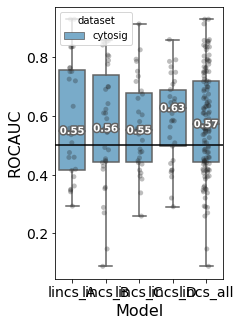

In [71]:
plot_results(rocaucs_dataframe, evaluation_metric = 'ROCAUC', save = False, filename = f'cytosig_ROCAUC_comparison_blue')


In [243]:
lr_associations[lr_associations['source_genesymbol'] == 'IL11']

,source_genesymbol,target_genesymbol
351,IL11,IL11RA
391,IL11,IL6ST


In [248]:
confidence_scores[(confidence_scores['Confidence'] == 'A') & (confidence_scores['Receptor'] == 'MRGPRX2')]

,Receptor,ROCAUC,Confidence
172,MRGPRX2,0.930085,A


In [487]:
rocaucs_dataframe[rocaucs_dataframe['model'] == 'lincs_A'].sort_values(by = 'auc')

,model,dataset,auc,receptor
3,lincs_A,cytosig,0.34744,MPL
1,lincs_A,cytosig,0.417113,RAMP3
5,lincs_A,cytosig,0.459165,MRGPRX2
2,lincs_A,cytosig,0.548618,TNFRSF14
0,lincs_A,cytosig,0.633559,CD40
4,lincs_A,cytosig,0.764378,TNFRSF1B


In [ ]:
# CNTFR, CALCRL, MRGPRX2, IL11RA, IL10RB, TNFRSF10D, TNFRSF10C, TNFRSF14, EPOR, RAMP3, MPL, RAMP1, LTBR

In [126]:
low_rec_list = ['CNTFR', 'CALCRL', 'MRGPRX2', 'IL11RA', 'IL10RB', 'TNFRSF10D', 'TNFRSF10C', 'TNFRSF14', 'EPOR', 'RAMP3', 'MPL', 'RAMP1', 'LTBR']
def select_rows_with_receptor(row):
    row_receptors = row.signed_interactions_rec
    receptor_keys = list(row_receptors.keys())
    lincs_a_list = rocaucs_dataframe[rocaucs_dataframe['model'] == 'lincs_A'].receptor.unique()
    if set(lincs_a_list) & set(receptor_keys):
        return [key for key in lincs_a_list if key in row_receptors]
    else:
        return np.nan


In [127]:
temp = cytosig_pert_types.copy()
temp = temp.dropna(subset = 'signed_interactions_rec')
# 

In [128]:
temp['lincs_A_receptors'] =  temp.apply(select_rows_with_receptor, axis = 1)

In [129]:
temp.dropna(subset = 'lincs_A_receptors')[['perturbation', 'lincs_A_receptors']].drop_duplicates(subset = 'perturbation')

,perturbation,lincs_A_receptors
IFNL&Duration:0.5h@Condition:Huh7@GSE48400.MicroArray.GPL10558,IFNL,[IL10RB]
IL10&Duration:5d@Condition:Macrophage.CCR5-using HIV-1 inoculated@GSE55029.MicroArray.GPL10558,IL10,[IL10RB]
LTA@Condition:Whole Blood.healthy adult&Duration:6h@GSE103500.MicroArray.GPL10558,LTA,"[TNFRSF14, LTBR]"
IL11@Condition:Cardiac fibroblasts&Duration:24h@GSE96975.RNASeq.SRP102374_GRCh38,IL11,[IL11RA]
IL22@Condition:primary keratinocytes@GSE12109.MicroArray.GPL571,IL22,[IL10RB]
TRAIL&Dose:25 ng/ml_Duration:8h@Condition:Melanoma_Me13@GSE55050.MicroArray.GPL10558,TRAIL,"[TNFRSF10D, TNFRSF10C]"
LTB@Condition:Caco-2@GSE1474.MicroArray.GPL96,LTB,[LTBR]
IL26@Condition:NHEK@GSE7216.MicroArray.HG-U133_Plus_2,IL26,[IL10RB]
"EPO@Condition:CD44+;CD24-;EpCAM+, SUM149 Cells@GSE51433.MicroArray.GPL4133",EPO,[EPOR]
ADM@Condition:Human lymphatic endothelial cells&Duration:0.25h@GSE59938.MicroArray.GPL4133,ADM,"[CALCRL, MRGPRX2, RAMP3, RAMP1]"


In [130]:
ligrectemp = pd.read_csv('data/receptor_ligand_association/liana_omni_receptor_ligand_interactions_curated.csv', index_col = 0)

In [131]:
ligrectemp[ligrectemp['source_genesymbol'].isin(temp.dropna(subset = 'lincs_A_receptors').perturbation.unique())]

,source_genesymbol,target_genesymbol,sources,curation_effort,n_resources
1,EPO,EPOR,Baccin2019;BioGRID;CellCall;CellChatDB;CellPho...,47,26
22,ADM,CALCRL,CellChatDB;CellTalkDB;Cellinker;EMBRACE;Fantom...,11,13
23,ADM,RAMP2,CellTalkDB;Cellinker;EMBRACE;Fantom5_LRdb;Guid...,9,11
32,ADM,RAMP3,CellTalkDB;Cellinker;Guide2Pharma;LRdb;Reactom...,7,5
36,ADM,CALCR,Baccin2019;CellChatDB;CellPhoneDB;CellTalkDB;C...,13,13
37,ADM,RAMP1,CellTalkDB;Cellinker;Guide2Pharma,6,3
175,ADM,MRGPRX2,Baccin2019;CellPhoneDB;Cellinker;Fantom5_LRdb;...,9,11
320,CNTF,CRLF1,HPMR;SIGNOR;SignaLink3;Wang,4,4
342,CNTF,CNTFR,Baccin2019;CellCall;CellTalkDB;DIP;DLRP_talklr...,27,18
351,IL11,IL11RA,Baccin2019;CellCall;CellTalkDB;DIP;DLRP_talklr...,20,18


In [137]:
lr_associations[lr_associations['source_genesymbol'] == 'ADM']

,source_genesymbol,target_genesymbol
22,ADM,CALCRL
23,ADM,RAMP2
32,ADM,RAMP3
36,ADM,CALCR
37,ADM,RAMP1
175,ADM,MRGPRX2
566,ADM,GPR182


In [138]:
ligrectemp[ligrectemp['source_genesymbol'] == 'ADM']

,source_genesymbol,target_genesymbol,sources,curation_effort,n_resources
22,ADM,CALCRL,CellChatDB;CellTalkDB;Cellinker;EMBRACE;Fantom...,11,13
23,ADM,RAMP2,CellTalkDB;Cellinker;EMBRACE;Fantom5_LRdb;Guid...,9,11
32,ADM,RAMP3,CellTalkDB;Cellinker;Guide2Pharma;LRdb;Reactom...,7,5
36,ADM,CALCR,Baccin2019;CellChatDB;CellPhoneDB;CellTalkDB;C...,13,13
37,ADM,RAMP1,CellTalkDB;Cellinker;Guide2Pharma,6,3
175,ADM,MRGPRX2,Baccin2019;CellPhoneDB;Cellinker;Fantom5_LRdb;...,9,11
566,ADM,GPR182,CellTalkDB;Cellinker;EMBRACE;Fantom5_LRdb;HPMR...,4,9


In [132]:
rocaucs_dataframe[rocaucs_dataframe['model'] == 'lincs_A']

,model,dataset,auc,receptor
0,lincs_A,cytosig,0.777489,AMHR2
1,lincs_A,cytosig,0.736565,TNFRSF1B
2,lincs_A,cytosig,0.75098,TNFRSF21
3,lincs_A,cytosig,0.12318,CNTFR
4,lincs_A,cytosig,0.63498,CD40
5,lincs_A,cytosig,0.471006,CALCRL
6,lincs_A,cytosig,0.437336,MRGPRX2
7,lincs_A,cytosig,0.727117,TNFRSF1A
8,lincs_A,cytosig,0.734907,IFNAR2
9,lincs_A,cytosig,0.178825,IL11RA
